In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

fake_df["label"] = 0 
true_df["label"] = 1 

df = pd.concat([fake_df,true_df])
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [4]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [5]:
df = df[["text", "title", "label"]].copy()
df.head()

,text,title,label
0,WASHINGTON (Reuters) - Senate Republican leade...,U.S. tax bill should include repeal of health ...,1
1,Career criminals professional grifters the ult...,PRICELESS: Watch Bill Clinton Defend Hillary’s...,0
2,"The Republican Party should be so fortunate, a...",IS CROOKED HILLARY Getting Ready To Compete Wi...,0
3,BEIRUT (Reuters) - An Iranian military vessel ...,U.S. denies Iran report of confrontation with ...,1
4,In response to the establishment media s con...,FAKE NEWS WEEK: Electronic Voting – The Big Li...,0


In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = tokenizer.tokenize(text)
    cleaned_text = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w)>2]
    return ' '.join(cleaned_text)

[nltk_data] Downloading package punkt to C:\Users\Allaa
[nltk_data]     Azzam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Allaa
[nltk_data]     Azzam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Allaa
[nltk_data]     Azzam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df["whole_text"] = df["title"] + " " + df["text"]
df["cleaned_text"] = df["whole_text"].apply(preprocess)

In [8]:
df.head()

,text,title,label,whole_text,cleaned_text
0,WASHINGTON (Reuters) - Senate Republican leade...,U.S. tax bill should include repeal of health ...,1,U.S. tax bill should include repeal of health ...,tax bill include repeal health insurance manda...
1,Career criminals professional grifters the ult...,PRICELESS: Watch Bill Clinton Defend Hillary’s...,0,PRICELESS: Watch Bill Clinton Defend Hillary’s...,priceless watch bill clinton defend hillary cr...
2,"The Republican Party should be so fortunate, a...",IS CROOKED HILLARY Getting Ready To Compete Wi...,0,IS CROOKED HILLARY Getting Ready To Compete Wi...,crooked hillary getting ready compete creepy j...
3,BEIRUT (Reuters) - An Iranian military vessel ...,U.S. denies Iran report of confrontation with ...,1,U.S. denies Iran report of confrontation with ...,denies iran report confrontation vessel beirut...
4,In response to the establishment media s con...,FAKE NEWS WEEK: Electronic Voting – The Big Li...,0,FAKE NEWS WEEK: Electronic Voting – The Big Li...,fake news week electronic voting big lie die r...


In [9]:
X = df["cleaned_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3 , random_state=42)

In [10]:
vectorizer = TfidfVectorizer() 
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [11]:
def save_model (model , modelname ) : 
    import pickle
    with open(modelname,'wb') as file:  
        pickle.dump(model,file) 
    print("model has been saved successfully")

In [12]:
save_model(vectorizer, "Fake_News_Vectorizer")

model has been saved successfully


<h2>Logistic Regression model</h2>

In [12]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train_tf,y_train)
y_pred = logistic.predict(X_test_tf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n ", classification_report(y_test,y_pred))

Accuracy: 0.9848552338530067
Classification Report:
                precision    recall  f1-score   support

           0       0.99      0.98      0.99      7032
           1       0.98      0.99      0.98      6438

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



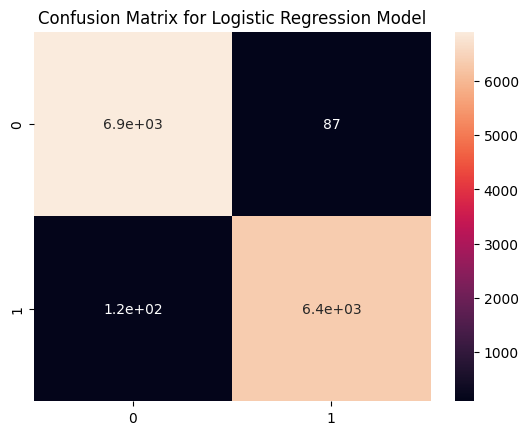

In [13]:
cm = confusion_matrix(y_pred, y_test) 
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

In [14]:
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000) )
scores = cross_val_score(pipeline, X,y , cv = 5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Average Accuracy:", scores.mean())

Cross-Validation Scores: [0.9863029  0.98685969 0.98552339 0.98830605 0.98719234]
Average Accuracy: 0.9868368707880872


In [15]:
save_model(pipeline, "Fake_news_detection_logistic_98.5%")

model has been saved successfully


<h2>Naive Bayes</h2>

In [16]:
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)
y_pred = nb.predict(X_test_tf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n ", classification_report(y_test,y_pred))

Accuracy: 0.9358574610244988
Classification Report:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94      7032
           1       0.94      0.92      0.93      6438

    accuracy                           0.94     13470
   macro avg       0.94      0.94      0.94     13470
weighted avg       0.94      0.94      0.94     13470



In [17]:
alpha_values = np.arange(0.1,1.0,0.1)
for alpha in alpha_values: 
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train_tf, y_train)
    y_pred = nb.predict(X_test_tf)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ", acc)

Accuracy:  0.94090571640683
Accuracy:  0.940014847809948
Accuracy:  0.9386785449146251
Accuracy:  0.938604305864885
Accuracy:  0.9374164810690423
Accuracy:  0.9370452858203415
Accuracy:  0.9365256124721604
Accuracy:  0.9365256124721604
Accuracy:  0.9359317000742391


In [18]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0.1) )
scores = cross_val_score(pipeline, X,y , cv = 5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Average Accuracy:", scores.mean())
y_pred = cross_val_predict(pipeline, X,y, cv=5 )
print(classification_report(y, y_pred))

Cross-Validation Scores: [0.94476615 0.94365256 0.93830735 0.94353491 0.9389687 ]
Average Accuracy: 0.9418459354926405
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     23481
           1       0.94      0.93      0.94     21417

    accuracy                           0.94     44898
   macro avg       0.94      0.94      0.94     44898
weighted avg       0.94      0.94      0.94     44898



<h2>Random Forest</h2>

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tf, y_train)
y_pred = rf.predict(X_test_tf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n ", classification_report(y_test,y_pred))

Accuracy: 0.9896807720861173
Classification Report:
                precision    recall  f1-score   support

           0       0.99      0.99      0.99      7032
           1       0.99      0.99      0.99      6438

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



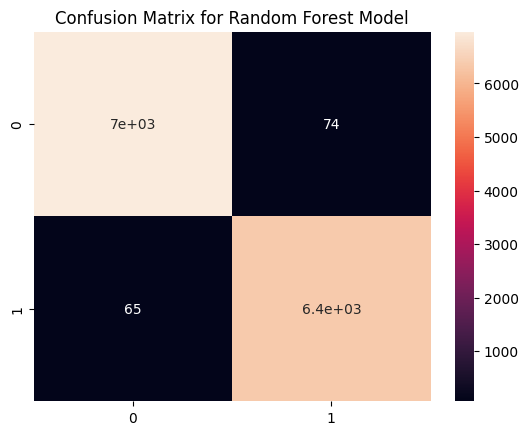

In [22]:
cm = confusion_matrix(y_pred, y_test) 
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

In [23]:
pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42) )
scores_rf = cross_val_score(pipeline_rf, X,y , cv = 5, scoring='accuracy')
print("Cross-Validation Scores:", scores_rf)
print("Average Accuracy:", scores_rf.mean())
y_pred = cross_val_predict(pipeline_rf, X,y, cv=5 )
print(classification_report(y, y_pred))

Cross-Validation Scores: [0.99242762 0.99276169 0.99187082 0.99142443 0.99142443]
Average Accuracy: 0.9919818006429753
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23481
           1       0.99      0.99      0.99     21417

    accuracy                           0.99     44898
   macro avg       0.99      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



In [25]:
importances = rf.feature_importances_
feature_names = vectorizer.get_feature_names_out() 

top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)
print(top_features)

reuters       0.069717
said          0.023555
video         0.019635
via           0.017608
image         0.015990
watch         0.010035
featured      0.009309
washington    0.008758
com           0.005999
wednesday     0.005340
dtype: float64


In [32]:
save_model(rf, "Fake_news_detection_RandomForest_98.9%")

model has been saved successfully


<h2>SVM</h2>

In [13]:
svc = LinearSVC()
svc.fit(X_train_tf, y_train)
y_pred = svc.predict(X_test_tf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n ", classification_report(y_test,y_pred))

Accuracy: 0.9947290274684484
Classification Report:
                precision    recall  f1-score   support

           0       1.00      0.99      0.99      7109
           1       0.99      1.00      0.99      6361

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



In [14]:
for c in [0.01,0.1, 1 , 10, 100]: 
    svc = LinearSVC(C=c)
    svc.fit(X_train_tf,y_train)
    pred = svc.predict(X_test_tf)
    print("Accuracy:", accuracy_score(y_test, pred))

Accuracy: 0.970007423904974
Accuracy: 0.9892353377876764
Accuracy: 0.9947290274684484
Accuracy: 0.9941351150705271
Accuracy: 0.9943578322197476


C:\Users\Allaa Azzam\anaconda\envs\new_env\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
save_model(svc, "Fake_news_detection_SVM_99.4%")

model has been saved successfully


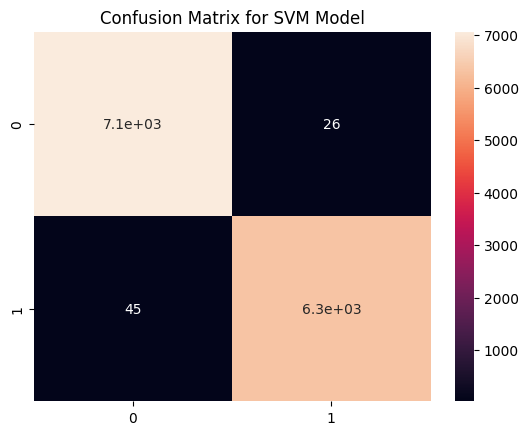

In [16]:
cm = confusion_matrix(y_pred, y_test) 
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix for SVM Model")
plt.show()